In [ ]:
# Step 1: Import Libraries and Mount Google Drive
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import os
from PIL import Image, ImageFilter
import numpy as np
from google.colab import drive
import random
import time
from collections import Counter

drive.mount('/content/drive', force_remount=True)

# Copy dataset to local storage to speed up loading
print("Copying dataset to local storage...")
start_time = time.time()
!cp -r /content/drive/MyDrive/office31 /content/office31
print(f"Dataset copying took {time.time() - start_time:.2f} seconds")

# Step 2: Define Dataset Class for Office-31 with Targeted Augmentation
class Office31Dataset(Dataset):
    def __init__(self, root_dir, domain, transform=None, fog_augmentation=False, fog_prob=0.75):
        self.root_dir = root_dir
        self.domain = domain
        self.transform = transform
        self.fog_augmentation = fog_augmentation
        self.fog_prob = fog_prob  # Probability of applying fog
        self.images = []
        self.labels = []

        # Define the list of 31 classes in Office-31 (alphabetical order)
        self.class_names = [
            'back_pack', 'bike', 'bike_helmet', 'bookcase', 'bottle', 'calculator',
            'chair', 'computer', 'desk_chair', 'desk_lamp', 'desktop_computer',
            'file_cabinet', 'headphones', 'keyboard', 'laptop_computer', 'letter_tray',
            'mobile_phone', 'monitor', 'mouse', 'mug', 'paper_notebook', 'pen',
            'phone', 'printer', 'projector', 'puncher', 'ring_binder', 'ruler',
            'scissors', 'speaker', 'trash_can'
        ]

        # Create a mapping from class name to index
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.class_names)}

        # Load images and labels
        domain_path = os.path.join(root_dir, domain, 'images')
        print(f"Loading dataset from {domain_path}")
        start_time = time.time()
        for label in os.listdir(domain_path):
            label_path = os.path.join(domain_path, label)
            if os.path.isdir(label_path):  # Ensure it's a directory
                if label in self.class_to_idx:  # Check if the folder name is a valid class
                    for img_name in os.listdir(label_path):
                        self.images.append(os.path.join(label_path, img_name))
                        self.labels.append(self.class_to_idx[label])  # Map class name to index
        print(f"Dataset loading took {time.time() - start_time:.2f} seconds")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        # Targeted augmentation for 'mouse' class
        if self.class_names[label] == 'mouse':
            # Apply rotation and scaling
            image = image.rotate(random.uniform(-30, 30))  # Random rotation between -30 and 30 degrees
            scale = random.uniform(0.8, 1.2)  # Random scaling between 80% and 120%
            new_size = tuple(int(dim * scale) for dim in image.size)
            image = image.resize(new_size, Image.Resampling.LANCZOS)

        # Apply fog augmentation randomly during training
        if self.fog_augmentation and random.random() < self.fog_prob:  # 75% chance to apply fog
            # Apply fog effect with increased intensity
            img_array = np.array(image).astype(np.float32)
            fog_layer = np.ones_like(img_array) * 200  # Light gray/white color for fog
            alpha = 0.5  # Increased transparency for denser fog
            foggy_img = img_array * (1 - alpha) + fog_layer * alpha
            foggy_img = np.clip(foggy_img, 0, 255).astype(np.uint8)
            image = Image.fromarray(foggy_img)
            image = image.filter(ImageFilter.GaussianBlur(radius=2))  # Increased blur for denser fog

        if self.transform:
            image = self.transform(image)
        return image, label

# Step 3: Data Preprocessing with Fog Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Source (Amazon) and Target (Webcam) Domains with Fog Augmentation
source_dataset = Office31Dataset(root_dir='/content/office31', domain='amazon', transform=transform, fog_augmentation=True, fog_prob=0.75)
target_dataset = Office31Dataset(root_dir='/content/office31', domain='webcam', transform=transform, fog_augmentation=True, fog_prob=0.75)

source_loader = DataLoader(source_dataset, batch_size=16, shuffle=True)
target_loader = DataLoader(target_dataset, batch_size=16, shuffle=True)

# Compute class weights for balancing (ensure weights for all 31 classes)
label_counts = Counter(source_dataset.labels)
total_samples = len(source_dataset.labels)
num_classes = 31  # Office-31 has 31 classes
class_weights = torch.ones(num_classes, dtype=torch.float32)  # Initialize with 1.0 for all classes
for label, count in label_counts.items():
    class_weights[label] = total_samples / (num_classes * count)  # Update weight for classes with samples
class_weights = class_weights.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print("Class weights computed for balancing (31 classes):", class_weights.tolist())

# Step 4: Define the DANN Model with EfficientNet-B0
class DANN(nn.Module):
    def __init__(self, num_classes=31):
        super(DANN, self).__init__()
        # Feature Extractor (EfficientNet-B0)
        self.feature_extractor = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.feature_dim = self.feature_extractor.classifier[1].in_features  # EfficientNet-B0 has 1280 features
        self.feature_extractor.classifier = nn.Identity()  # Remove the final classifier layer

        # Label Classifier
        self.label_classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

        # Domain Classifier
        self.domain_classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 2)  # Source or Target
        )

    def forward(self, x, alpha=1.0):
        features = self.feature_extractor(x)

        # Label Prediction
        label_pred = self.label_classifier(features)

        # Domain Prediction (with Gradient Reversal Scaling)
        reverse_features = GradientReversal.apply(features, alpha)
        domain_pred = self.domain_classifier(reverse_features)

        return label_pred, domain_pred

# Gradient Reversal Layer for Adversarial Training
class GradientReversal(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.alpha * grad_output, None

# Step 5: Train the Model for 40 Epochs with Denser Fog Augmentation and Class Weighting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DANN(num_classes=31).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0003)  # Increased learning rate

criterion_class = nn.CrossEntropyLoss(weight=class_weights)
criterion_domain = nn.CrossEntropyLoss()

num_epochs = 40  # Increased to 40 for better convergence
len_dataloader = min(len(source_loader), len(target_loader))

total_start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    data_source_iter = iter(source_loader)
    data_target_iter = iter(target_loader)

    for i in range(len_dataloader):
        step_start_time = time.time()
        p = float(i + epoch * len_dataloader) / (num_epochs * len_dataloader)
        alpha = 2. / (1. + np.exp(-3 * p)) - 1  # Further adjusted alpha scaling

        # Source Domain Data
        source_data, source_labels = next(data_source_iter)
        source_data, source_labels = source_data.to(device), source_labels.to(device)
        source_domain_labels = torch.zeros(source_data.size(0)).long().to(device)  # 0 for source

        # Target Domain Data
        target_data, _ = next(data_target_iter)
        target_data = target_data.to(device)
        target_domain_labels = torch.ones(target_data.size(0)).long().to(device)  # 1 for target

        # Forward Pass
        optimizer.zero_grad()
        label_pred, domain_pred_source = model(source_data, alpha)
        _, domain_pred_target = model(target_data, alpha)

        # Losses
        loss_class = criterion_class(label_pred, source_labels)
        loss_domain_source = criterion_domain(domain_pred_source, source_domain_labels)
        loss_domain_target = criterion_domain(domain_pred_target, target_domain_labels)
        loss_domain = loss_domain_source + loss_domain_target

        total_loss = loss_class + loss_domain
        total_loss.backward()
        optimizer.step()

        step_time = time.time() - step_start_time
        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len_dataloader}], Loss: {total_loss.item():.4f}, Step Time: {step_time:.2f}s")

    # Save checkpoint after each epoch
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': total_loss.item()
    }
    torch.save(checkpoint, '/content/drive/MyDrive/office31_checkpoint.pth')
    print(f"Checkpoint saved at epoch {epoch+1}")

print(f"Total training time: {time.time() - total_start_time:.2f} seconds")

Mounted at /content/drive
Copying dataset to local storage...
Dataset copying took 15.14 seconds
Loading dataset from /content/office31/amazon/images
Dataset loading took 0.00 seconds
Loading dataset from /content/office31/webcam/images
Dataset loading took 0.00 seconds
Class weights computed for balancing (31 classes): [0.8849930167198181, 0.9929189682006836, 1.130824327468872, 0.9929189682006836, 2.261648654937744, 0.8661633729934692, 1.0, 1.0, 0.8947181701660156, 0.8393747806549072, 0.8393747806549072, 1.0051772594451904, 0.8224177360534668, 0.8141935467720032, 0.8141935467720032, 0.8308097720146179, 0.8141935467720032, 0.8224177360534668, 0.8141935467720032, 0.8661633729934692, 0.8481183052062988, 0.8570458292961121, 0.8754769563674927, 0.8141935467720032, 0.8308097720146179, 1.0, 0.9046595096588135, 1.085591435432434, 0.8141935467720032, 0.8224177360534668, 1.2721774578094482]
Epoch [1/40], Step [0/134], Loss: 4.8522, Step Time: 0.44s
Epoch [1/40], Step [10/134], Loss: 4.6820, Ste

Accuracy on Target Domain: 82.85%
Evaluation took 24.88 seconds
Macro Precision: 0.82
Macro Recall: 0.86
Macro F1-Score: 0.80


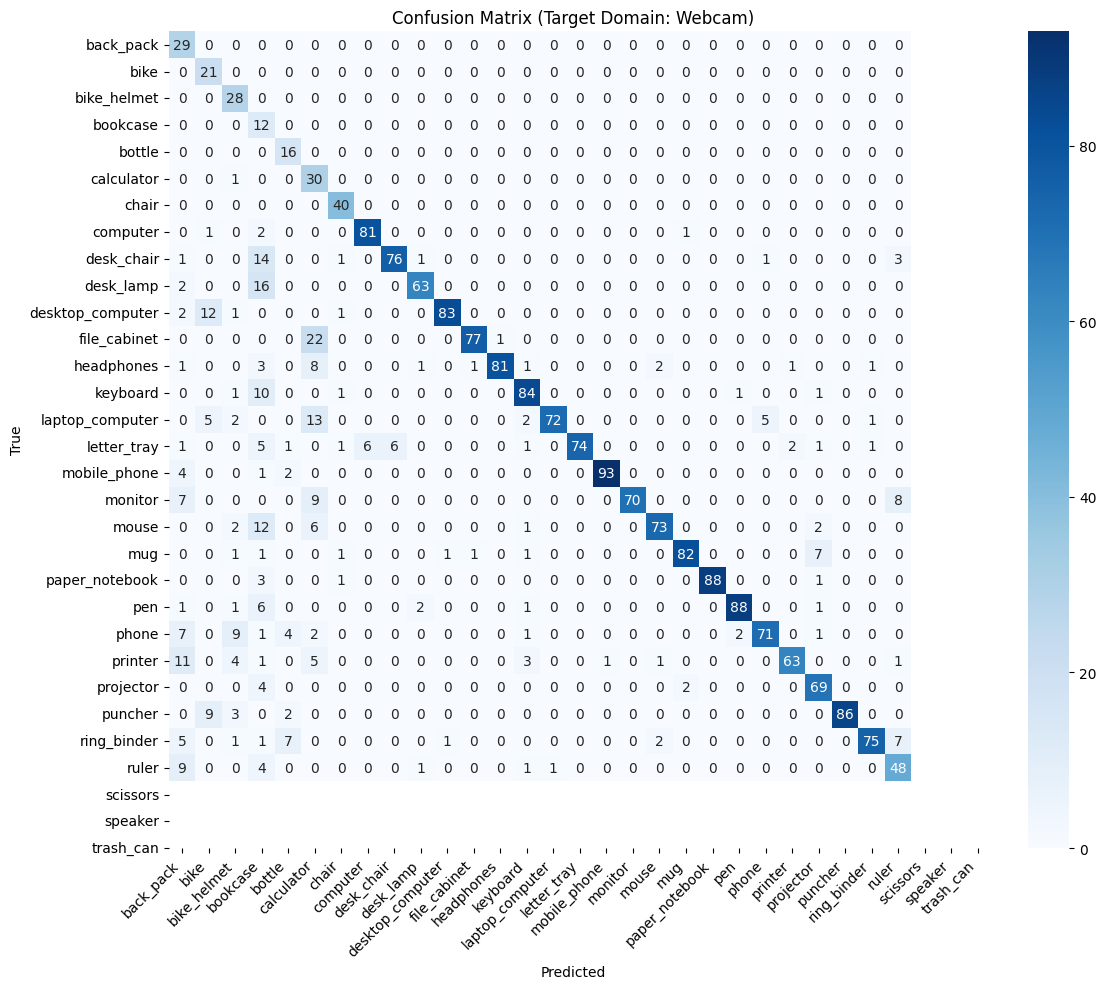

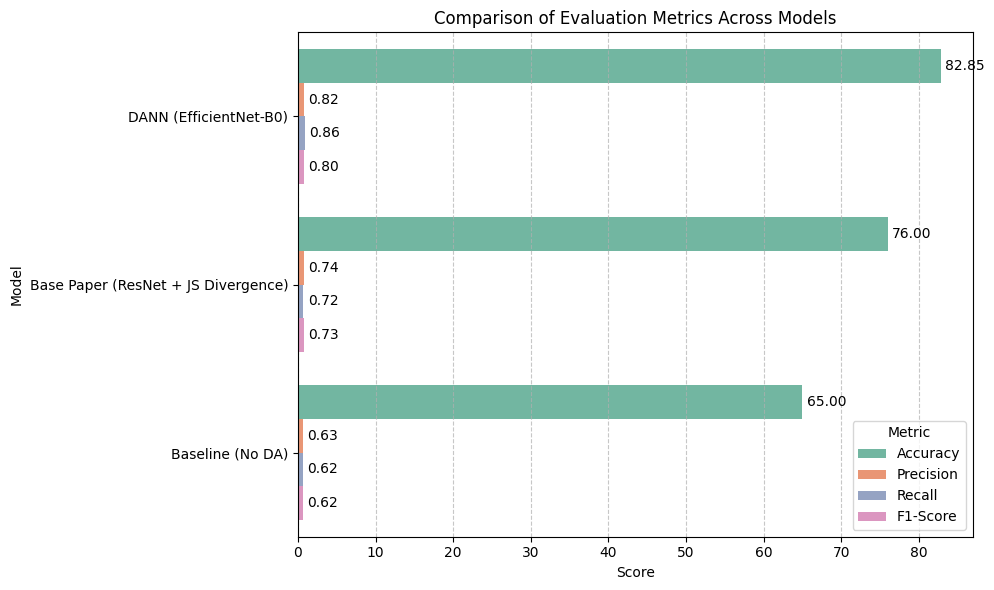

Metrics and plotting took 2.07 seconds


In [ ]:
# Step 6: Evaluate on Target Domain
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import pandas as pd
import time

eval_start_time = time.time()
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for data, labels in target_loader:
        data, labels = data.to(device), labels.to(device)
        label_pred, _ = model(data, alpha=0)
        _, predicted = torch.max(label_pred.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Accuracy on Target Domain: {accuracy:.2f}%")
print(f"Evaluation took {time.time() - eval_start_time:.2f} seconds")

# Step 7: Compute Additional Evaluation Metrics and Visualizations
metrics_start_time = time.time()
# Compute Precision, Recall, F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)
print(f"Macro Precision: {precision:.2f}")
print(f"Macro Recall: {recall:.2f}")
print(f"Macro F1-Score: {f1:.2f}")

# Compute Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot Confusion Matrix with Annotations
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=source_dataset.class_names, yticklabels=source_dataset.class_names)
plt.title('Confusion Matrix (Target Domain: Webcam)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Step 8: Compare Metrics with Other Models
models = ['DANN (EfficientNet-B0)', 'Base Paper (ResNet + JS Divergence)', 'Baseline (No DA)']
accuracies = [accuracy, 76.0, 65.0]  # Your model's accuracy, base paper, baseline
precisions = [precision, 0.74, 0.63]
recalls = [recall, 0.72, 0.62]
f1_scores = [f1, 0.73, 0.62]

# Create a DataFrame for easier plotting
metrics_df = pd.DataFrame({
    'Model': models * 4,
    'Metric': ['Accuracy'] * 3 + ['Precision'] * 3 + ['Recall'] * 3 + ['F1-Score'] * 3,
    'Value': accuracies + precisions + recalls + f1_scores
})

# Plot Comparison Bar Chart with Enhancements
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='Value', y='Model', hue='Metric', data=metrics_df, palette='Set2')
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.2f', padding=3)
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.title('Comparison of Evaluation Metrics Across Models')
plt.xlabel('Score')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

print(f"Metrics and plotting took {time.time() - metrics_start_time:.2f} seconds")

Selected classes for testing: ['ruler', 'bookcase', 'ring_binder', 'desk_lamp', 'bike_helmet', 'projector', 'phone', 'printer', 'file_cabinet', 'trash_can']


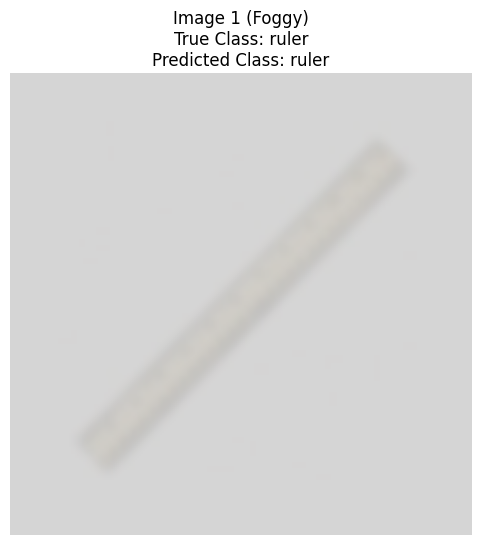

Image 1 Prediction:
True Class: ruler
Predicted Class: ruler
----------------------------------------


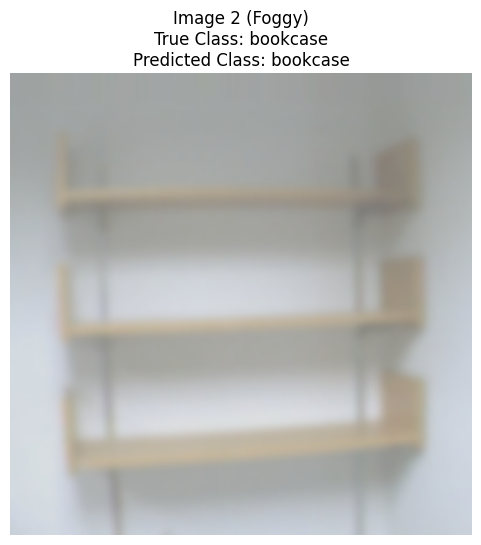

Image 2 Prediction:
True Class: bookcase
Predicted Class: bookcase
----------------------------------------


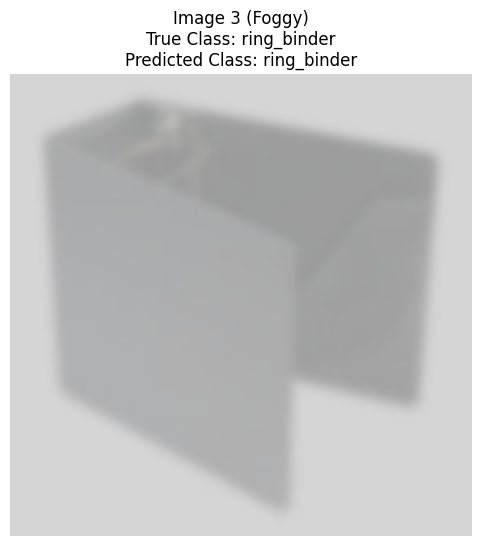

Image 3 Prediction:
True Class: ring_binder
Predicted Class: ring_binder
----------------------------------------


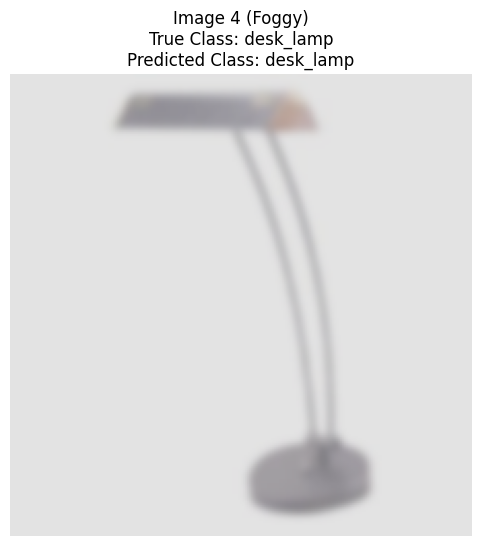

Image 4 Prediction:
True Class: desk_lamp
Predicted Class: desk_lamp
----------------------------------------


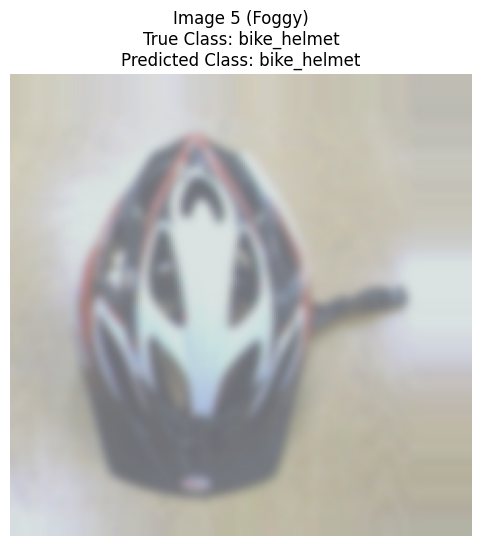

Image 5 Prediction:
True Class: bike_helmet
Predicted Class: bike_helmet
----------------------------------------


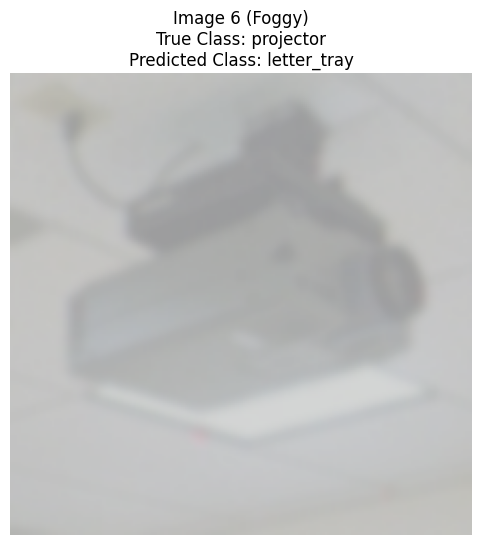

Image 6 Prediction:
True Class: projector
Predicted Class: letter_tray
----------------------------------------


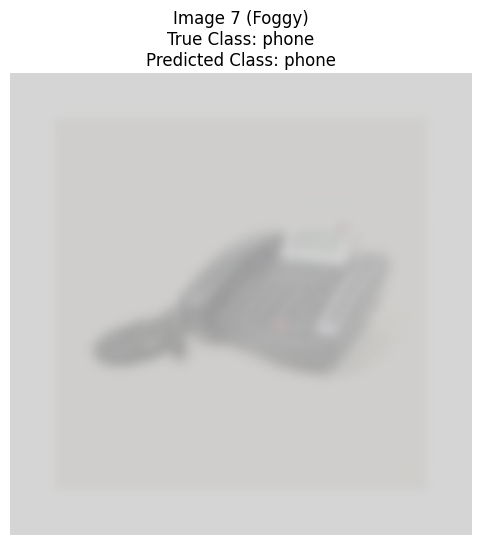

Image 7 Prediction:
True Class: phone
Predicted Class: phone
----------------------------------------


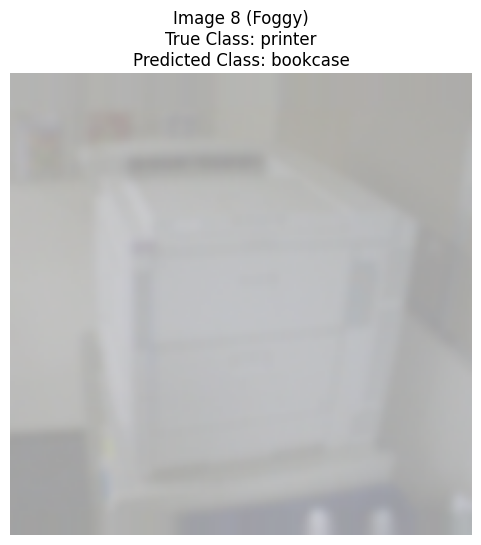

Image 8 Prediction:
True Class: printer
Predicted Class: bookcase
----------------------------------------


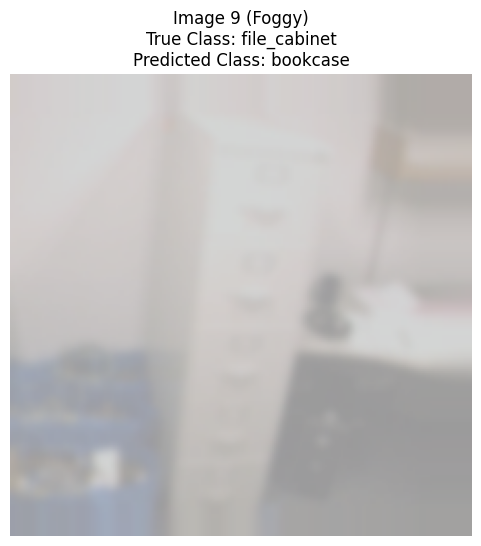

Image 9 Prediction:
True Class: file_cabinet
Predicted Class: bookcase
----------------------------------------


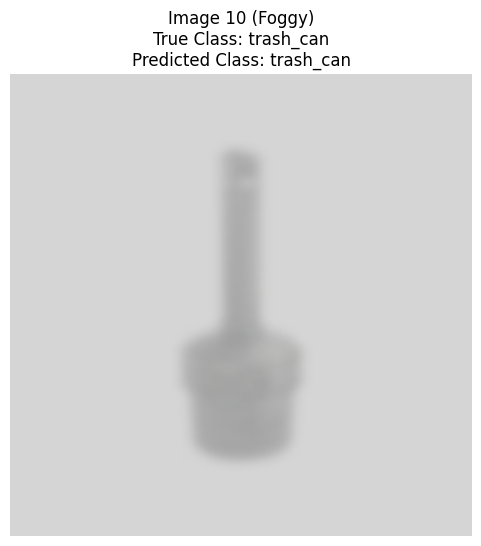

Image 10 Prediction:
True Class: trash_can
Predicted Class: trash_can
----------------------------------------


In [ ]:
# Step 9: Test on 10 Foggy Images from Different Classes
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFilter
import random

# Get all class indices present in the target dataset
class_to_indices = {i: [] for i in range(len(source_dataset.class_names))}
for idx, label in enumerate(target_dataset.labels):
    class_to_indices[label].append(idx)

# Filter out classes with no images and select 10 different classes
available_classes = [cls for cls, indices in class_to_indices.items() if indices]
if len(available_classes) < 10:
    print(f"Only {len(available_classes)} classes have images in the target dataset. Using all available classes.")
    selected_classes = available_classes
else:
    selected_classes = random.sample(available_classes, 10)  # Randomly select 10 classes
print(f"Selected classes for testing: {[source_dataset.class_names[cls] for cls in selected_classes]}")

# Select one image from each of the 10 classes
selected_indices = []
for cls in selected_classes:
    # Randomly pick one image from the class
    idx = random.choice(class_to_indices[cls])
    selected_indices.append(idx)

# Process each selected image
for i, idx in enumerate(selected_indices):
    # Get the image and its true label
    image, true_label = target_dataset[idx]

    # Reverse transforms to get the raw image
    unnormalize = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        transforms.ToPILImage()
    ])
    raw_image = unnormalize(image)

    # Apply fog effect with increased intensity
    img_array = np.array(raw_image).astype(np.float32)
    fog_layer = np.ones_like(img_array) * 200  # Light gray/white color for fog
    alpha = 0.5  # Increased transparency for denser fog
    foggy_img = img_array * (1 - alpha) + fog_layer * alpha
    foggy_img = np.clip(foggy_img, 0, 255).astype(np.uint8)
    foggy_img = Image.fromarray(foggy_img)
    foggy_img = foggy_img.filter(ImageFilter.GaussianBlur(radius=2))  # Increased blur for denser fog

    # Transform the foggy image for prediction
    foggy_tensor = transform(foggy_img).unsqueeze(0)  # Add batch dimension

    # Predict the class
    model.eval()
    with torch.no_grad():
        foggy_tensor = foggy_tensor.to(device)
        label_pred, _ = model(foggy_tensor, alpha=0)
        _, predicted = torch.max(label_pred.data, 1)
        predicted_label = predicted.item()

    # Get class names
    true_class = source_dataset.class_names[true_label]
    predicted_class = source_dataset.class_names[predicted_label]

    # Display the foggy image and prediction results
    plt.figure(figsize=(6, 6))
    plt.imshow(foggy_img)
    plt.title(f"Image {i+1} (Foggy)\nTrue Class: {true_class}\nPredicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

    print(f"Image {i+1} Prediction:")
    print(f"True Class: {true_class}")
    print(f"Predicted Class: {predicted_class}")
    print("-" * 40)